# Erkennung von EKG Anomalien mit Hilfe eines Autoencoders

<br/>
<div>
<img src="Autoencoder.png" width="600"/>
</div>

Ein Autoencoder ist eine spezielle Form von Neuralem Netzwerk. Beispielsweise wird ein Bild einer handgeschriebenen Zahl vom Autoencoder zunächst in ein Bild mit weniger Dimensionen codiert. Anschließend wird das reduzierte Bild wieder decodiert, wobei versucht wird den Rekonstruktionsfehler zu minimieren.

Dieses Verfahren kann genutzt werden um Anomalien in EKGs zu erkennen. Dazu wird das Modell nur mit Daten normaler EKGs trainiert, jedoch mit dem kompletten Datensatz getestet. Daraus ergibt sich bei der Rekonstruktion abnormaler EKGs ein größerer Rekonstruktionsfehler. Übersteigt die Größe des Fehlers eine definierte Schwelle, wird das EKG als abnormal kategorisiert.


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model

In [2]:
df = pd.read_csv('Input/ecg.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


Der Datensatz verfügt über 140 Spalten. Die letzte Spalte enthält die Werte 0 und 1, was für abnormales bzw. normales EKG steht und dient somit als Label.

In [3]:
# Separieren von Daten und Labels
data = df.iloc[:,:-1].values
labels = df.iloc[:,-1].values
labels

array([1., 1., 1., ..., 0., 0., 0.])

In [4]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.2, random_state = 21) # Aufteilung: Testsatz, Trainingssatz

**Normalisierung im Bereich [0-1]**

Wir verwenden dafür folgende Formel:
<br/>
<div>
<img src="Formel.png" width="600"/>
</div>

In [5]:
# Maximum und Minimum des Trainingssets berechnen
min = tf.reduce_min(train_data)
max = tf.reduce_max(train_data)

# Verwenden der Formel (data - min)/(max - min)
train_data = (train_data - min)/(max - min)
test_data = (test_data - min)/(max - min)

# Konvertieren der Daten zu float
train_data = tf.cast(train_data, dtype=tf.float32)
test_data = tf.cast(test_data, dtype=tf.float32)

In [6]:
# Da die Labels 0 oder 1 sind können sie zu Booleschen Weten konvertiert werden (true, false)
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

# Separieren der Daten von normalen EKGs von Daten abnormaler EKGs
#Normale EKG-Daten
n_train_data = train_data[train_labels]
n_test_data = test_data[test_labels]

#Abnormale EkG-Daten
an_train_data = train_data[~train_labels]
an_test_data = test_data[~test_labels]

print(n_train_data)

tf.Tensor(
[[0.57030463 0.46561658 0.29058117 ... 0.48504233 0.4233502  0.47598344]
 [0.48320588 0.28246963 0.16471253 ... 0.567567   0.4677294  0.2692329 ]
 [0.48144642 0.35151404 0.25972766 ... 0.5479421  0.5077544  0.54298663]
 ...
 [0.41039047 0.24164985 0.13120876 ... 0.5277313  0.5654091  0.5023885 ]
 [0.5397748  0.4140786  0.28101394 ... 0.51266515 0.43706053 0.4426865 ]
 [0.29639772 0.15988176 0.18883787 ... 0.53766966 0.545786   0.40826708]], shape=(2359, 140), dtype=float32)


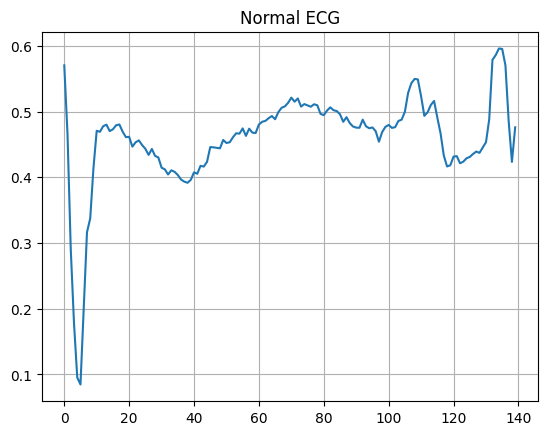

In [7]:
# Plot eines normalen EKG
plt.plot(np.arange(140), n_train_data[0])
plt.grid()
plt.title('Normal ECG')
plt.show()

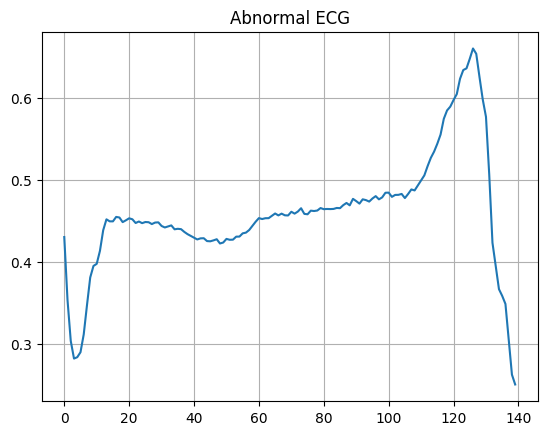

In [8]:
# Plot eines abnormalen EKG
plt.plot(np.arange(140), an_train_data[0])
plt.grid()
plt.title('Abnormal ECG')
plt.show()

In [9]:
# Definition des Modells
# Das Modell besteht aus2 Teilen : 1. Encoder and 2. Decoder
 
class detector(Model):
  def __init__(self):
    super(detector, self).__init__()
    self.encoder = tf.keras.Sequential([
                                        layers.Dense(32, activation='relu'),
                                        layers.Dense(16, activation='relu'),
                                        layers.Dense(8, activation='relu')
    ])
    self.decoder = tf.keras.Sequential([
                                        layers.Dense(16, activation='relu'),
                                        layers.Dense(32, activation='relu'),
                                        layers.Dense(140, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [10]:
# Kompilieren und Training
autoencoder = detector()
autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.fit(n_train_data, n_train_data, epochs = 20, batch_size=512, validation_data=(n_test_data, n_test_data))

Epoch 1/20
5/5 [==============================] - 1s 52ms/step - loss: 0.0563 - val_loss: 0.0537
Epoch 2/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0523 - val_loss: 0.0497
Epoch 3/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0482 - val_loss: 0.0455
Epoch 4/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0440 - val_loss: 0.0414
Epoch 5/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0401 - val_loss: 0.0377
Epoch 6/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0365 - val_loss: 0.0344
Epoch 7/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0335 - val_loss: 0.0318
Epoch 8/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0311 - val_loss: 0.0295
Epoch 9/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0289 - val_loss: 0.0274
Epoch 10/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0269 - val_loss: 0.0256
Epoch 11/20
5/5 [=====================

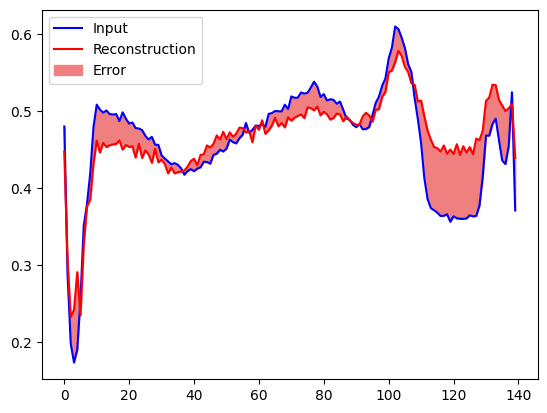

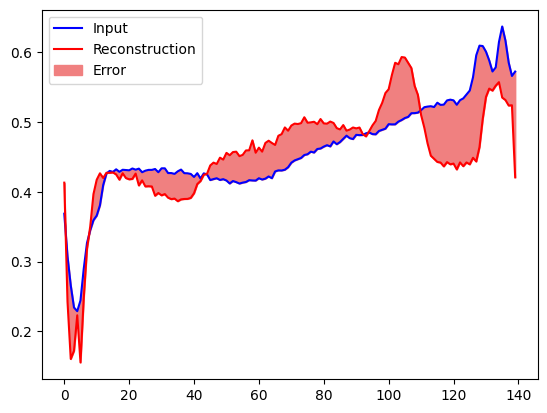

In [11]:
# Definition einer Funktion zum Plot des originalen EKG und seiner Rekonstruktion inklusive des Fehlers
def plot(data, n):
  enc_img = autoencoder.encoder(data)
  dec_img = autoencoder.decoder(enc_img)
  plt.plot(data[n], 'b')
  plt.plot(dec_img[n], 'r')
  plt.fill_between(np.arange(140), data[n], dec_img[n], color = 'lightcoral')
  plt.legend(labels=['Input', 'Reconstruction', 'Error'])
  plt.show()

plot(n_test_data, 0)
plot(an_test_data, 0)

In [12]:
# Festlegen des Schwellenwerts für den Fehler
reconstructed = autoencoder(n_train_data)
train_loss = losses.mae(reconstructed, n_train_data)
t = np.mean(train_loss) + np.std(train_loss)  # Schwelle als Standartabweichung vom Mittelwert
def prediction(model, data, threshold):
  rec = model(data)
  loss = losses.mae(rec, data)
  return tf.math.less(loss, threshold)
print(t)

0.02998276


In [13]:
pred = prediction(autoencoder, n_test_data, t)
print(pred)

tf.Tensor(
[False  True  True False  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
 False  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  Tr

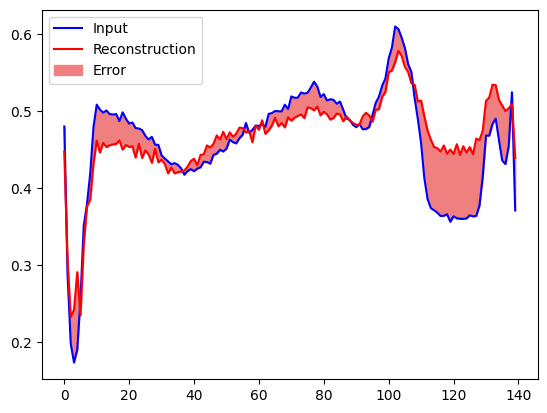

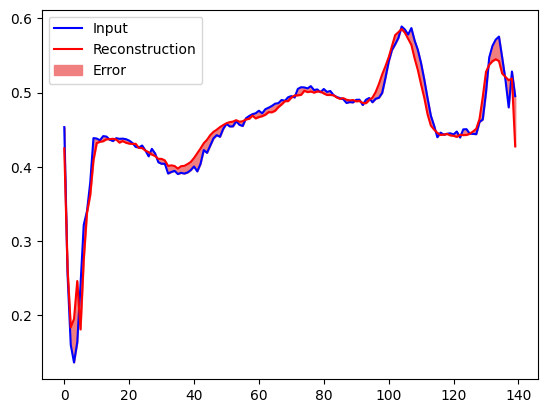

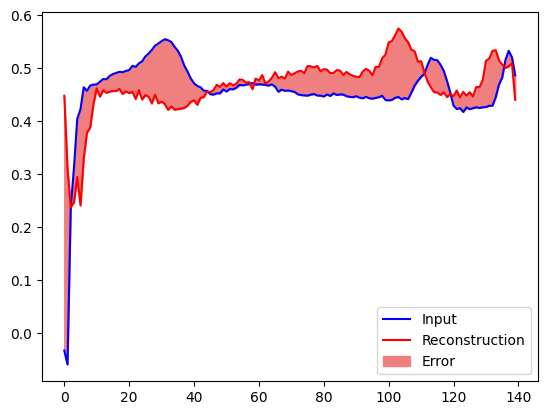

In [14]:
# Darstellung weiterer Ergebnisse
plot(n_test_data, 0)
plot(n_test_data, 1)
plot(n_test_data, 3)